# Analyzing Tour de Zwift performance
I am looking for anything interesting that I can find based on my performance in 8 races over 6 weeks

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import fitparse

In [2]:
def parseFitFile(file_path):
    
    fitfile = fitparse.FitFile(file_path)
    
    series = []
    
    for record in fitfile.get_messages("record"):

        row = {
            'altitude': np.NAN,
            'cadence': np.NAN,
            'distance': np.NAN,
            'heart_rate': np.NAN,
            'power': np.NAN,
            'speed': np.NAN,
            'timestamp': np.NAN
        }
        for data in record:
            if data.name in ['altitude','cadence','distance','heart_rate','power','speed','timestamp'] and data.value:
                row[data.name] = data.value

        if row['timestamp']:
            series += [row]
            
    df = pd.DataFrame(series)
#     df = df.set_index('timestamp')
    
    return df

## Importing Data

Reading ".fit" files from the races

In [3]:
FILE_FORMAT = "../Downloads/tdz-stage{}.fit"
dfs = {}
for i in range(1,9):
    f = FILE_FORMAT.format(i)
    ride = "TDZ-{}".format(i)
    print(f)
    dfs[ride] = parseFitFile(f)

../Downloads/tdz-stage1.fit
../Downloads/tdz-stage2.fit
../Downloads/tdz-stage3.fit
../Downloads/tdz-stage4.fit
../Downloads/tdz-stage5.fit
../Downloads/tdz-stage6.fit
../Downloads/tdz-stage7.fit
../Downloads/tdz-stage8.fit


## Setting the lengths of each Stage
Copied this data from zwift's TDZ webpage

In [4]:
n = ["TDZ-1","TDZ-2","TDZ-3","TDZ-4","TDZ-5","TDZ-6","TDZ-7","TDZ-8"]
l = [40.7,32.8,22.9,42.6,40.3,35.4,37.1,32.9]
stages = pd.DataFrame(zip(n,l),columns=["Stage","Length"])
stages

,Stage,Length
0,TDZ-1,40.7
1,TDZ-2,32.8
2,TDZ-3,22.9
3,TDZ-4,42.6
4,TDZ-5,40.3
5,TDZ-6,35.4
6,TDZ-7,37.1
7,TDZ-8,32.9


## Trimming Session Data
Post the race I did varying duration of cool down and varying intensity. This extra data will skew our results. We need to remove the data beyond the race distance. 

For example you can see Stage 8 data. Power drops significantly after 32.9kms.

<AxesSubplot:xlabel='distance'>

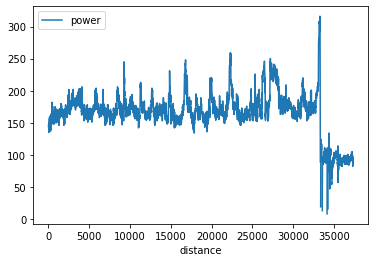

In [5]:
dfs['TDZ-8'].plot("distance","power")

We remove the extra data and you see the following clean graph:

<AxesSubplot:xlabel='distance'>

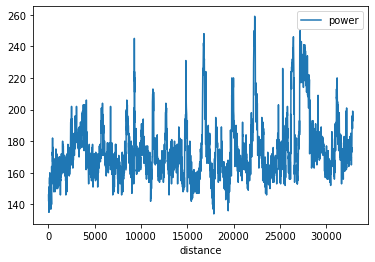

In [6]:
limit = stages[stages['Stage'] == 'TDZ-8'].Length.values[0]

temp = dfs['TDZ-8']
temp = temp[temp['distance'] <= (limit*1000)]
temp.plot("distance","power")

Doing this cleaning for all the stages

In [7]:
for ride in stages['Stage']:
    temp = dfs[ride]
    
    limit = stages[stages['Stage'] == ride].Length.values[0]

    temp = temp[temp['distance'] <= (limit*1000)]
    dfs[ride] = temp

## Ploting Power & Cadence
I tried ploting the rides together to see a pattern but it wasn't very clear. There is a lot of noise in the power data especially - even though I am pedalling continuously it records 0 Watts every now and then.

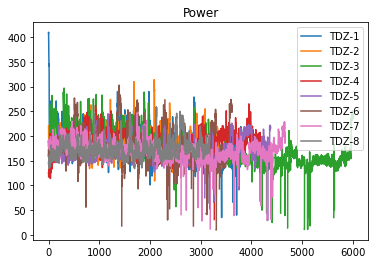

In [8]:
power = {}
for key in dfs:
    power[key] = dfs[key]['power']
    
powerDF = pd.DataFrame(power)
powerDF.plot()
plt.title("Power")
plt.show()

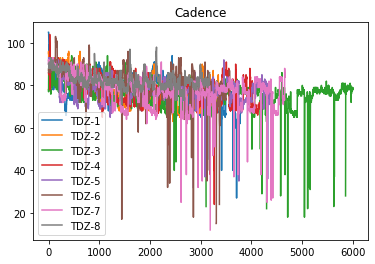

In [9]:
cadence = {}
for key in dfs:
    cadence[key] = dfs[key]['cadence']
    
cadenceDF = pd.DataFrame(cadence)
cadenceDF.plot()
plt.title("Cadence")
plt.show()

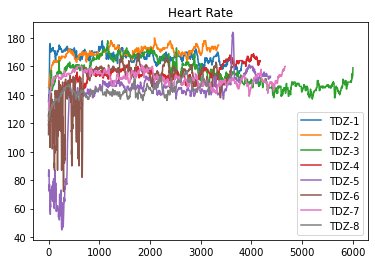

In [10]:
heartrate = {}
for key in dfs:
    heartrate[key] = dfs[key]['heart_rate']
    
heartrateDF = pd.DataFrame(heartrate)
heartrateDF.plot()
plt.title("Heart Rate")
plt.show()

## Smoothening the curves
Smoothening the lines to reduce the noise

In [11]:
!pip install tsmoothie

We can see a comparison of the original graph vs the new graph. Notice the smoothened graph has a shorter range (doesn't go down to 30)

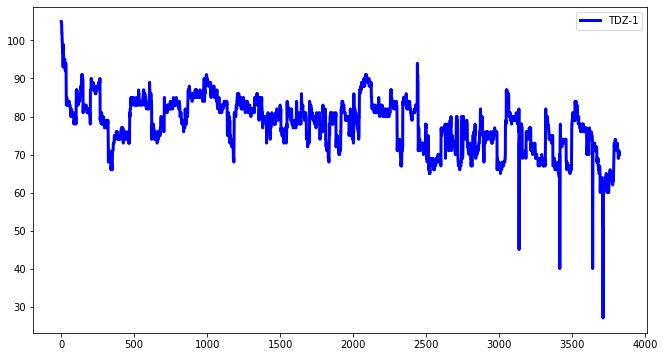

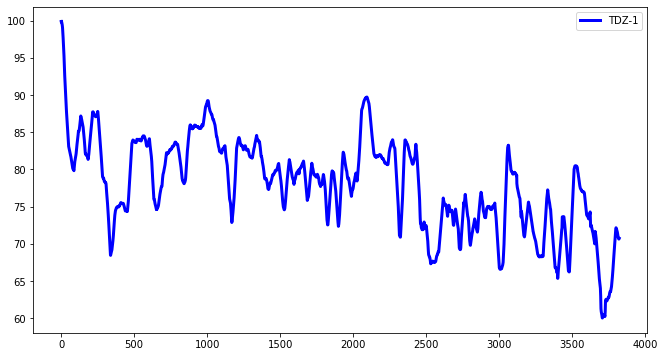

In [12]:
# https://stackoverflow.com/a/63575467
from tsmoothie.smoother import *

y = cadenceDF['TDZ-1'].dropna()

# operate smoothing
smoother = ConvolutionSmoother(window_len=30, window_type='ones')
smoother.smooth(y)

# plot original
plt.figure(figsize=(11,6))
plt.plot(y, linewidth=3, color='blue', label='TDZ-1')
plt.legend()
plt.show()

# plot the smoothed timeseries with intervals
plt.figure(figsize=(11,6))
plt.plot(smoother.smooth_data[0], linewidth=3, color='blue', label='TDZ-1')
plt.legend()
plt.show()

## Ploting as subplots
Ploting power & cadence as subplots

In [13]:
import matplotlib.cm as cm

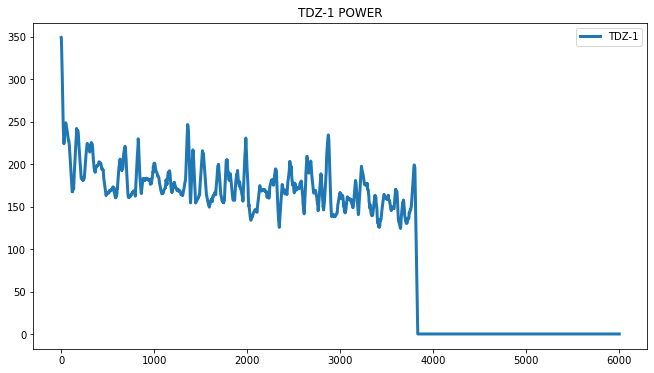

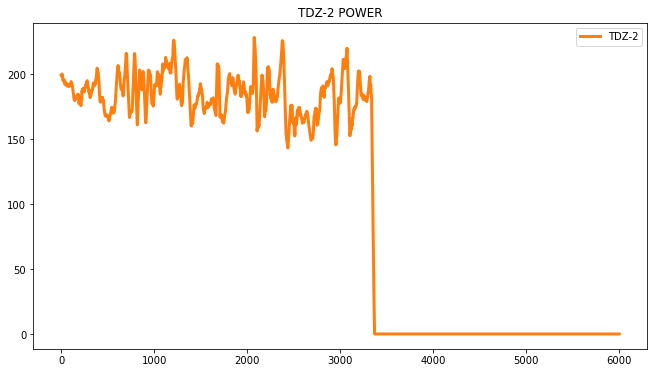

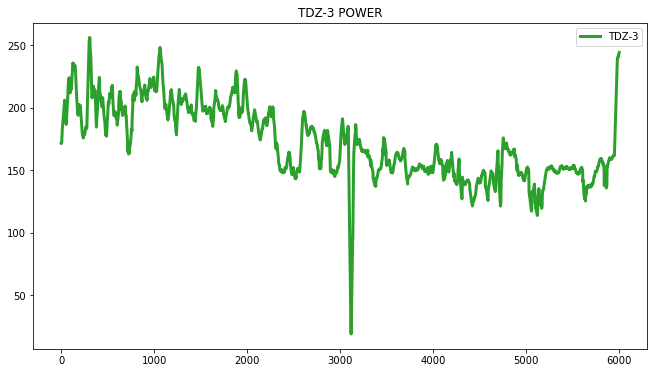

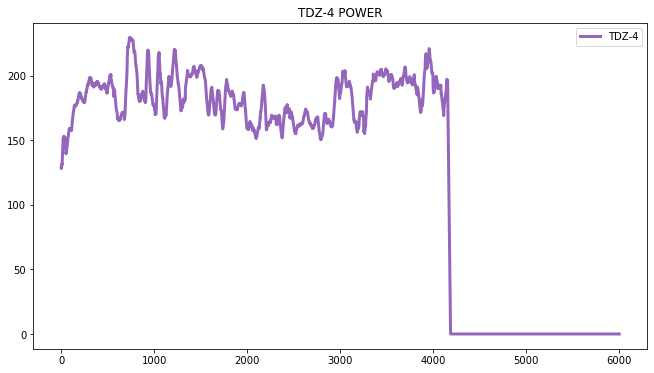

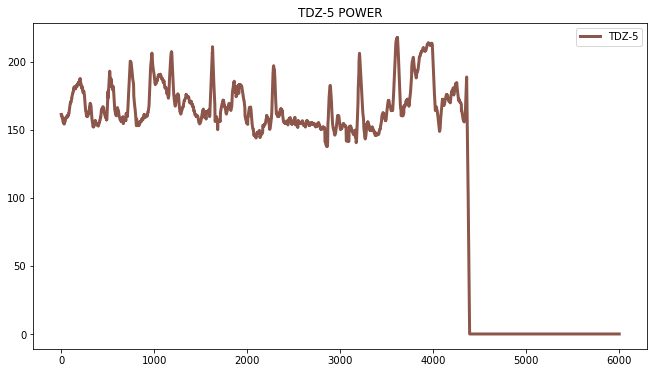

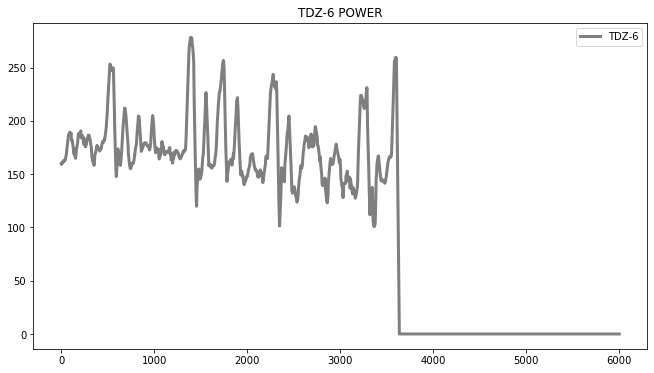

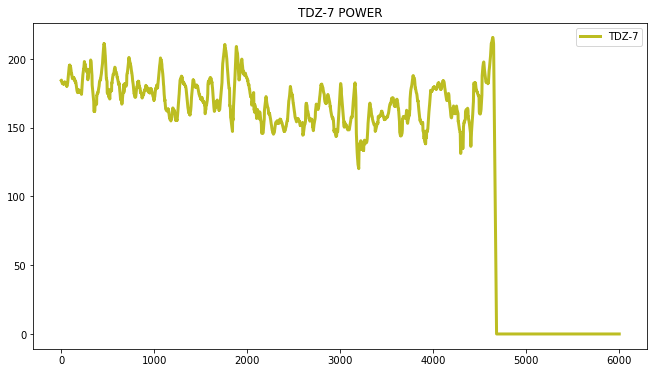

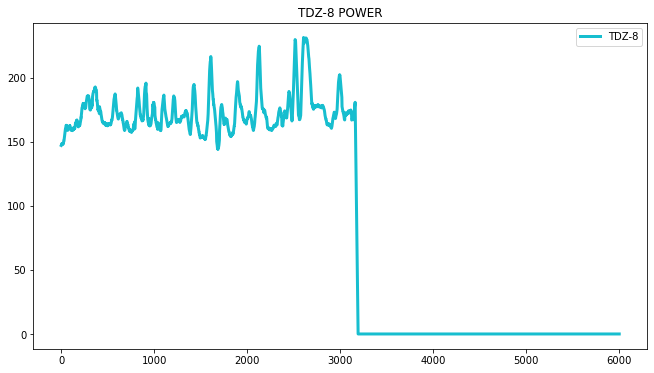

In [14]:
color = cm.tab10(np.linspace(0, 1, 8))

i = 0
for key in dfs:
    
    y = powerDF[key].fillna(0)

    # operate smoothing
    smoother = ConvolutionSmoother(window_len=30, window_type='ones')
    smoother.smooth(y)

    # plot the smoothed timeseries with intervals
    plt.figure(figsize=(11,6))
    plt.plot(smoother.smooth_data[0], linewidth=3, color=color[i], label=key)
    plt.legend()
    plt.title("{} POWER".format(key))
#     plt.ylim([60,110])
    plt.show()
    i+=1

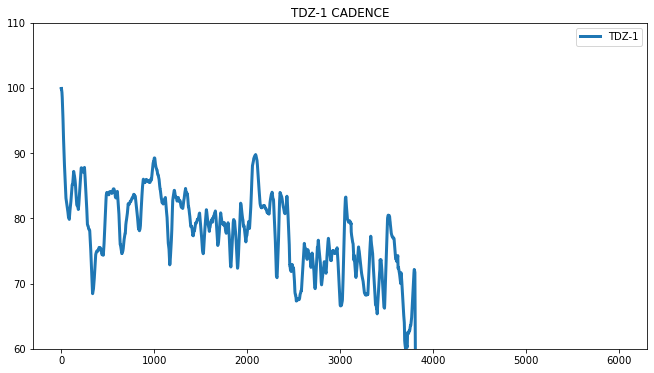

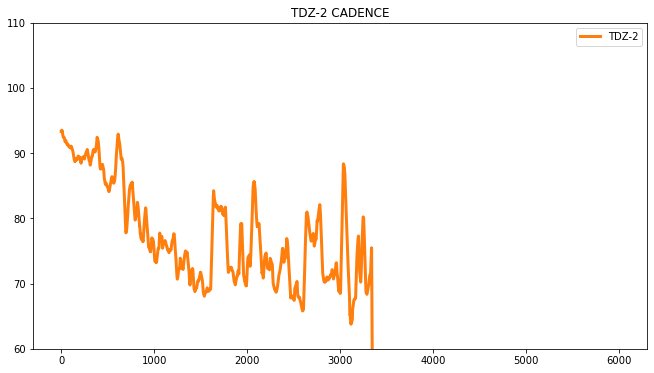

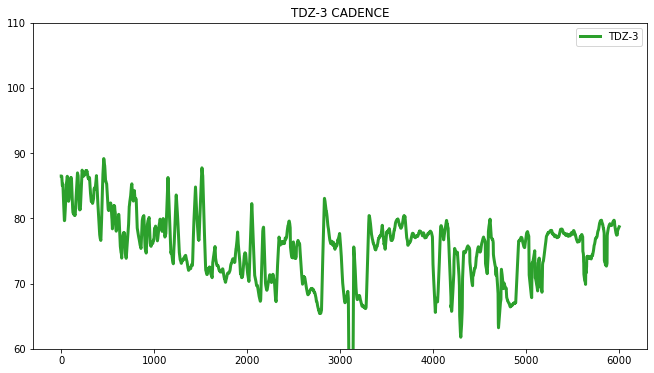

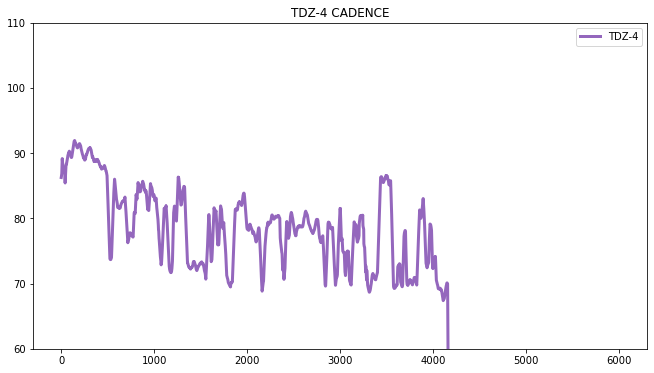

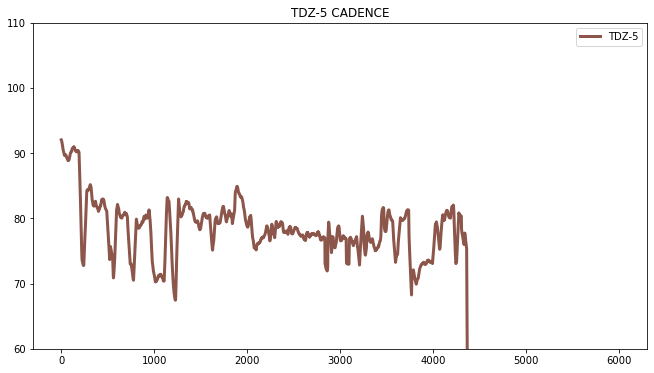

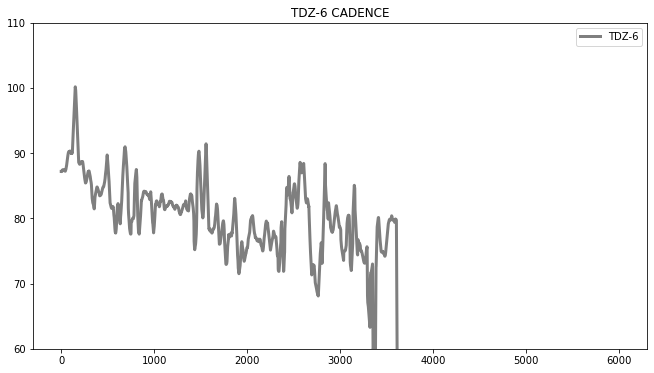

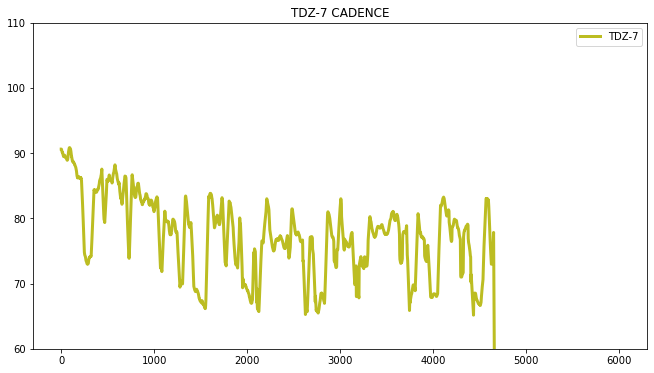

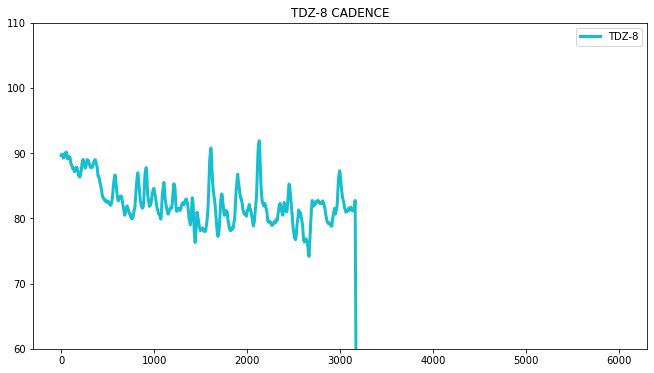

In [15]:
color = cm.tab10(np.linspace(0, 1, 8))

i = 0
for key in dfs:
    
    y = cadenceDF[key].fillna(0)

    # operate smoothing
    smoother = ConvolutionSmoother(window_len=30, window_type='ones')
    smoother.smooth(y)

    # plot the smoothed timeseries with intervals
    plt.figure(figsize=(11,6))
    plt.plot(smoother.smooth_data[0], linewidth=3, color=color[i], label=key)
    plt.legend()
    plt.title("{} CADENCE".format(key))
    plt.ylim([60,110])
    plt.show()
    i+=1

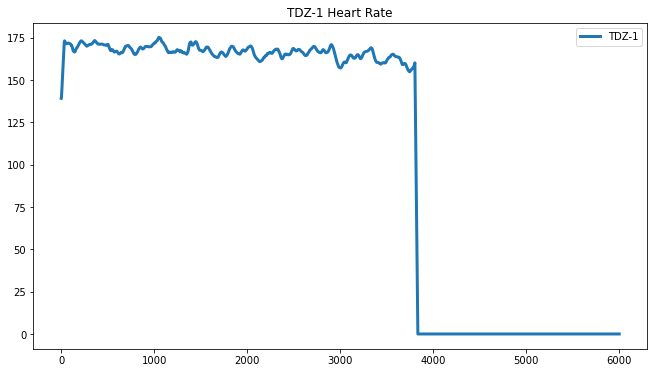

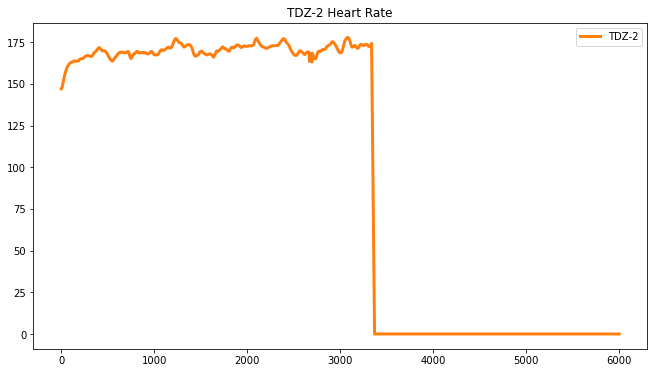

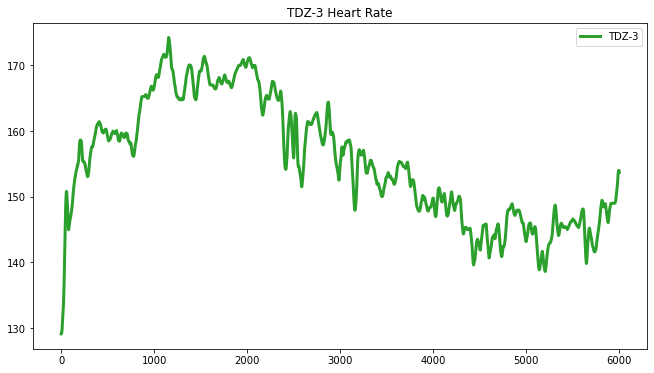

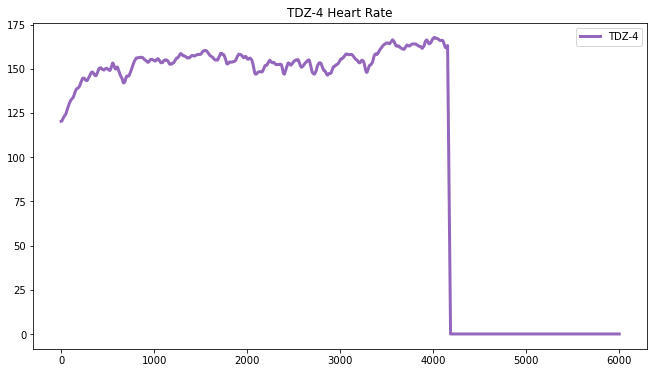

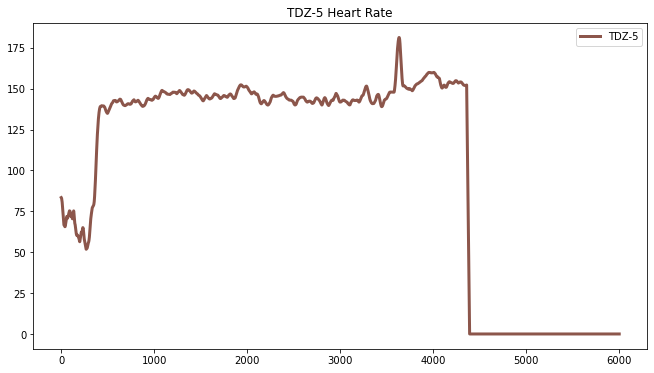

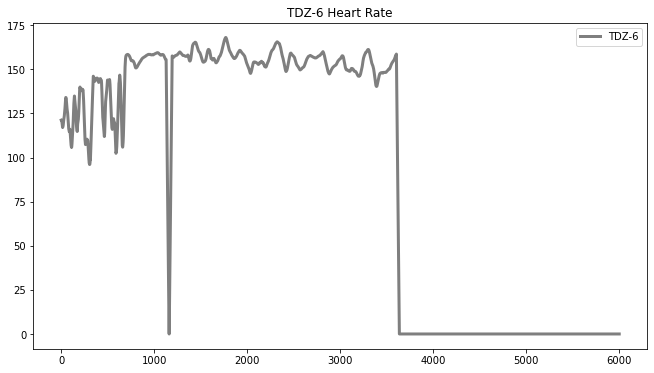

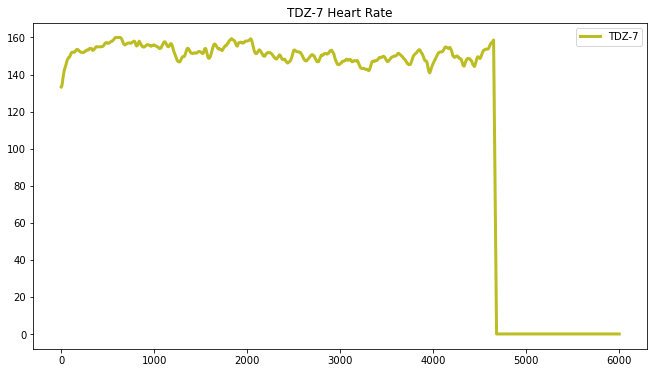

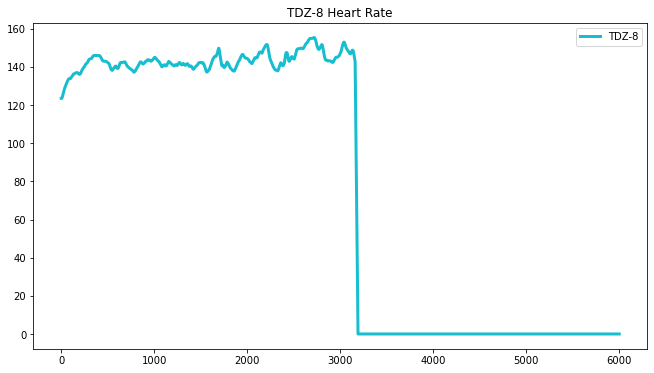

In [16]:
color = cm.tab10(np.linspace(0, 1, 8))

i = 0
for key in dfs:
    
    y = heartrateDF[key].fillna(0)

    # operate smoothing
    smoother = ConvolutionSmoother(window_len=30, window_type='ones')
    smoother.smooth(y)

    # plot the smoothed timeseries with intervals
    plt.figure(figsize=(11,6))
    plt.plot(smoother.smooth_data[0], linewidth=3, color=color[i], label=key)
    plt.legend()
    plt.title("{} Heart Rate".format(key))
#     plt.ylim([100,180])
    plt.show()
    i+=1

## Ploting a trendline
A trend line will help us understand better the improvement

In [17]:
def plotParameter(dfs, parameter,ylim):
    num_plots = len(dfs)
    color = cm.tab10(np.linspace(0, 1, num_plots))

    fig, axs = plt.subplots(num_plots, sharex=True, sharey=True, gridspec_kw={'hspace': 0})
    fig.set_size_inches(20, 20)

    i = 0
    for key in dfs:
        
        x = dfs[key].index
        y = dfs[key][parameter]
        
        y2 = y.fillna(0)
                
        # https://stackoverflow.com/a/26447505
        z = np.polyfit(x,y, 1)
        p = np.poly1d(z)

        
        # operate smoothing
        smoother = ConvolutionSmoother(window_len=30, window_type='ones')
        smoother.smooth(y2)
        
        axs[i].plot(smoother.smooth_data[0],linewidth=3, label=key,color=color[i])
        axs[i].plot(x,p(x),"r--",label="y=%.4fx+(%.4f)"%(z[0],z[1]))
        
        axs[i].legend()
        i+=1

    # Hide x labels and tick labels for all but bottom plot.
    for ax in axs:
        ax.label_outer()
#         ax.ylim(ylim)
#         ax.title(parameter)

Ploting candence. In the legend you can see the equation for the trendline.

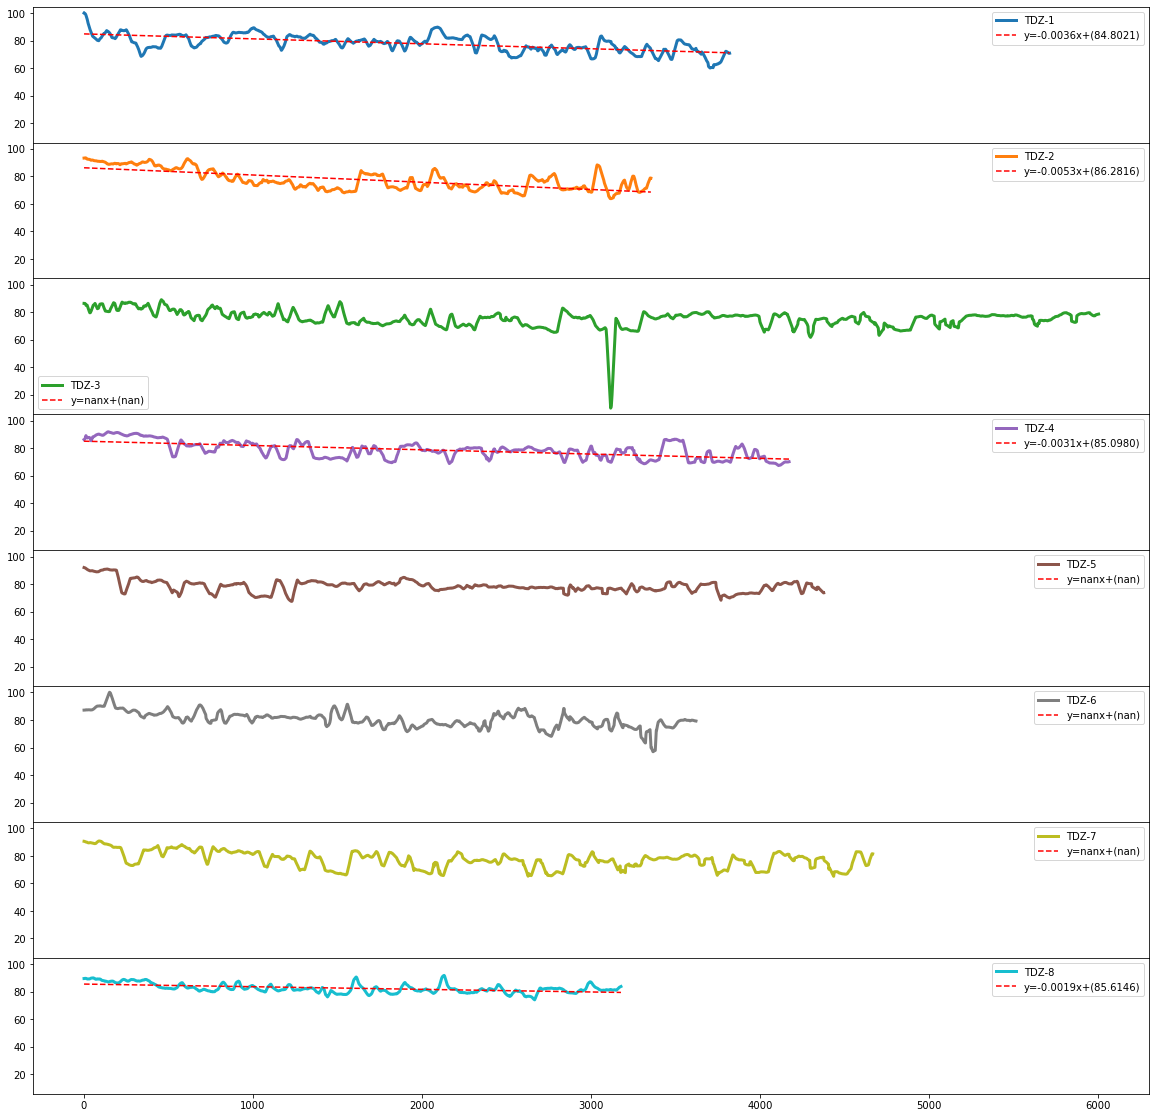

In [18]:
plotParameter(dfs,'cadence',[60,100])

Ploting power. In the legend you can see the equation for the trendline.

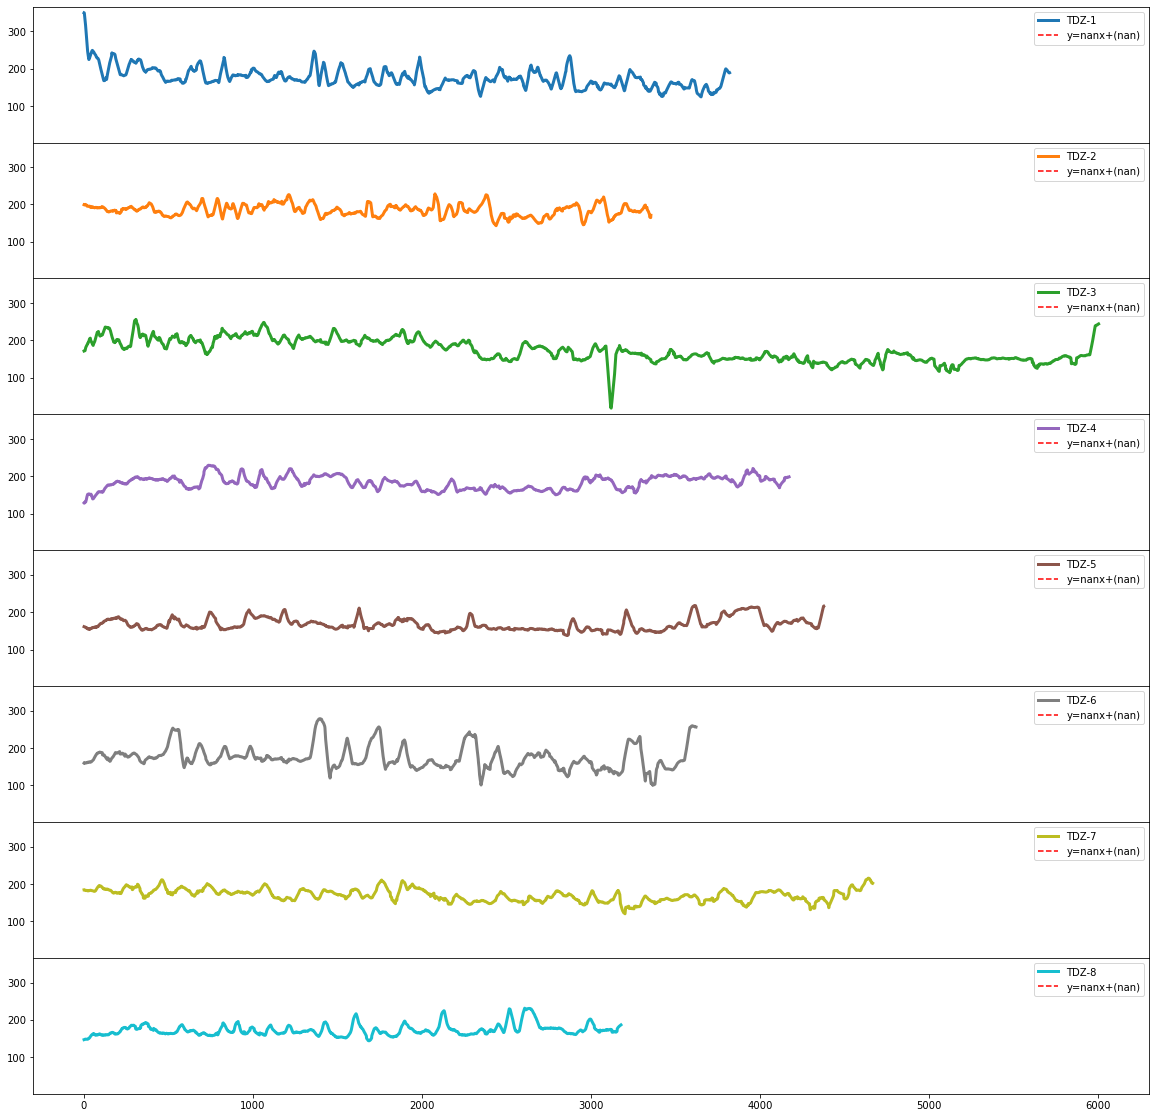

In [19]:
plotParameter(dfs,'power',[100,450])

Ploting heart rate. In the legend you can see the equation for the trendline.

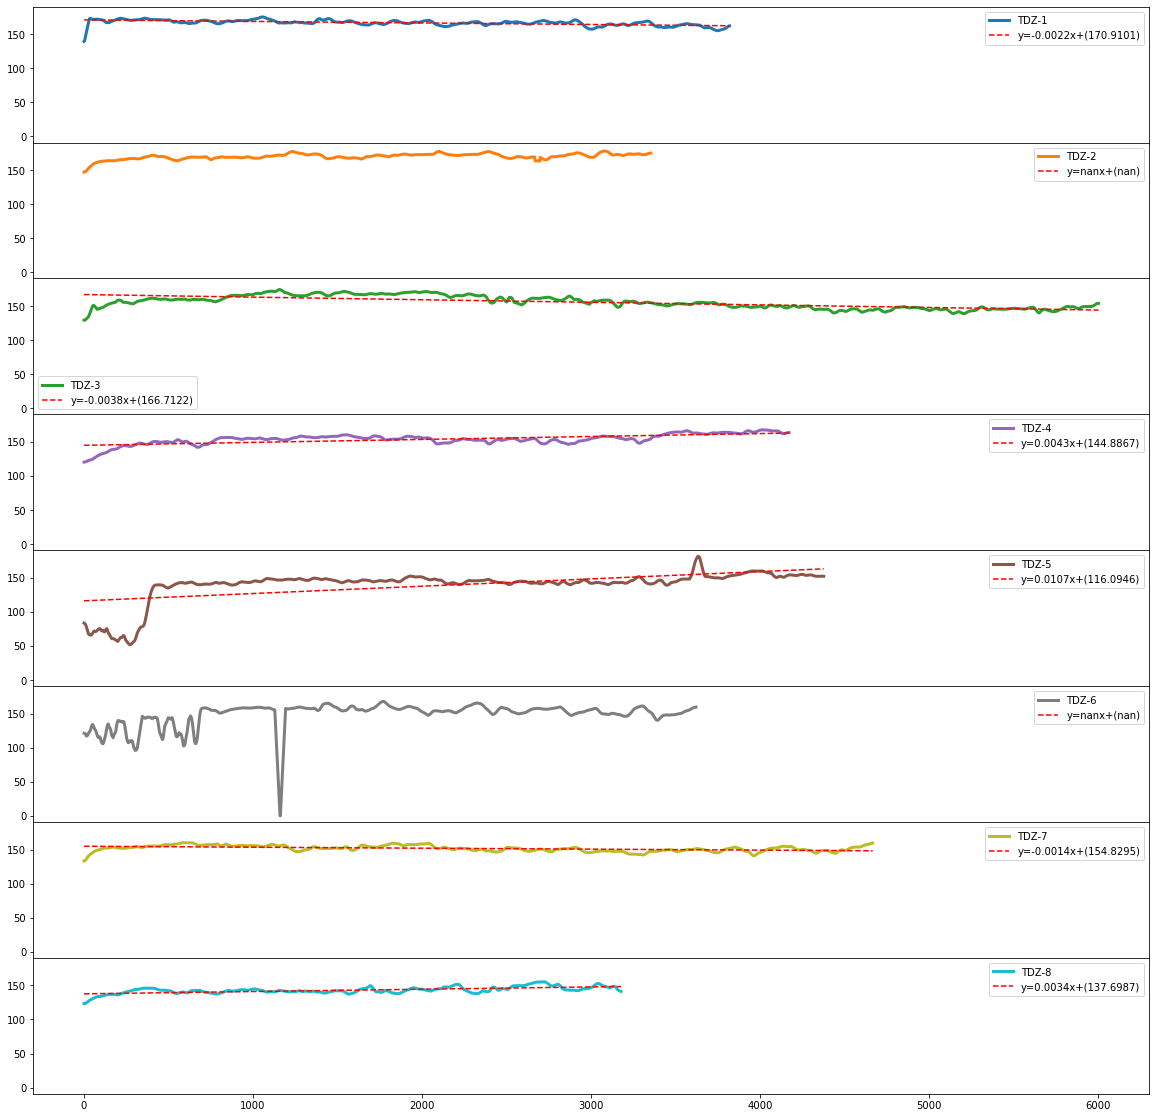

In [21]:
plotParameter(dfs,'heart_rate',[100,180])

## Looking at averages
Plotting averages for the ride to see if we can get any insights? Clearly the average cadence has moved up while the average power has come down

In [22]:
avgCadence = {'name':[],'average':[]}
for key in dfs:    
    avgCadence['name'] += [key]
    avgCadence['average'] += [np.average(dfs[key]['cadence'].dropna())]
    
avgPower = {'name':[],'average':[]}
for key in dfs:    
    avgPower['name'] += [key]
    avgPower['average'] += [np.average(dfs[key]['power'].dropna())]
    
avgHR = {'name':[],'average':[]}
for key in dfs:    
    avgHR['name'] += [key]
    avgHR['average'] += [np.average(dfs[key]['heart_rate'].dropna())]    

<AxesSubplot:title={'center':'Cadence'}>

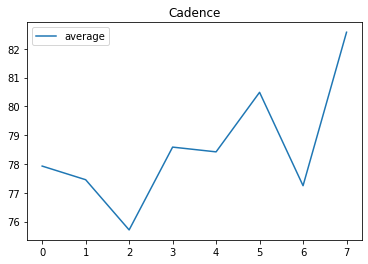

In [23]:
pd.DataFrame(avgCadence).plot(title='Cadence')

<AxesSubplot:title={'center':'Power'}>

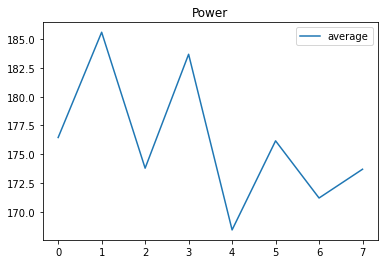

In [24]:
pd.DataFrame(avgPower).plot(title='Power')

<AxesSubplot:title={'center':'Heart Rate'}>

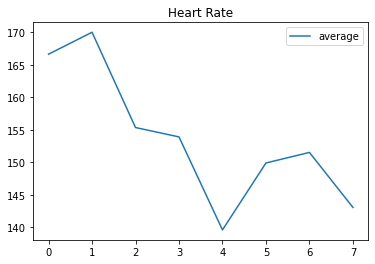

In [25]:
pd.DataFrame(avgHR).plot(title='Heart Rate')